# Traffic

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [24]:
df = pd.read_csv('data_exe/traffic.csv')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17551 entries, 0 to 17550
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date_time       17551 non-null  object 
 1   temp            17551 non-null  float64
 2   rain_1h         17551 non-null  float64
 3   snow_1h         17551 non-null  int64  
 4   clouds_all      17551 non-null  int64  
 5   traffic_volume  17551 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 822.8+ KB


In [26]:
df.head()

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume
0,2016-09-29 17:00:00,291.75,0.0,0,0,5551.0
1,2016-09-29 18:00:00,290.36,0.0,0,0,4132.0
2,2016-09-29 19:00:00,287.86,0.0,0,0,3435.0
3,2016-09-29 20:00:00,285.91,0.0,0,0,2765.0
4,2016-09-29 21:00:00,284.31,0.0,0,0,2443.0


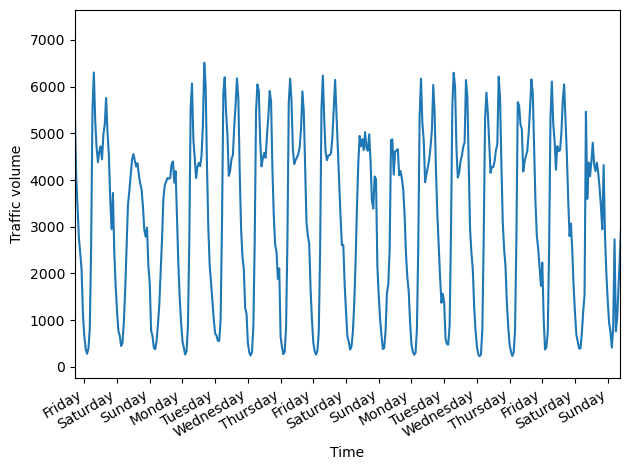

In [27]:
fig, ax = plt.subplots()
ax.plot(df['traffic_volume'])
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 
                                   'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
                                   'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                                   'Saturday', 'Sunday'])
plt.xlim(0, 400)
fig.autofmt_xdate()
plt.tight_layout()

## Feature Engineering

In [28]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,17551.0,281.416203,12.688262,243.39,272.22,282.41,291.89,310.07
rain_1h,17551.0,0.025523,0.259794,0.00,0.00,0.00,0.00,10.60
snow_1h,17551.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
clouds_all,17551.0,42.034129,39.065960,0.00,1.00,40.00,90.00,100.00
traffic_volume,17551.0,3321.484588,1969.223949,113.00,1298.00,3518.00,4943.00,7280.00


In [29]:
cols_to_drop = ['rain_1h', 'snow_1h']
df = df.drop(cols_to_drop, axis=1)

In [30]:
import datetime

In [31]:
# express the date as a number of seconds
timestamp_s = pd.to_datetime(df['date_time']).map(datetime.datetime.timestamp)

In [32]:
day = 24 * 60 * 60
df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values

In [33]:
df = df.drop(['date_time'], axis=1)

## Train, Validation, Test Split

In [34]:
n = len(df)
# Split 70:20:10 (train:validation:test)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [35]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
scaler = MinMaxScaler()
scaler.fit(train_df)

MinMaxScaler()

In [37]:
train_df.loc[:, train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df.loc[:, val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df.loc[:, test_df.columns] = scaler.transform(test_df[test_df.columns])

/var/folders/8k/8n8mf6jn28537sc4vvz36rhh0000gn/T/ipykernel_1262/4151412436.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.   0.   0.   ... 0.9  0.75 0.4 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_df.loc[:, train_df.columns] = scaler.transform(train_df[train_df.columns])
/var/folders/8k/8n8mf6jn28537sc4vvz36rhh0000gn/T/ipykernel_1262/4151412436.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.01 0.2  0.05 ... 0.9  0.9  0.9 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  val_df.loc[:, val_df.columns] = scaler.transform(val_df[val_df.columns])
/var/folders/8k/8n8mf6jn28537sc4vvz36rhh0000gn/T/ipykernel_1262/4151412436.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Valu

In [38]:
train_df.to_csv('data_exe/train.csv')
val_df.to_csv('data_exe/val.csv')
test_df.to_csv('data_exe/test.csv')

## Data Window

In [ ]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels

In [39]:
t = pd.read_csv('data_exe/train.csv')

In [40]:
t.head()

,Unnamed: 0,temp,clouds_all,traffic_volume,day_sin,day_cos
0,0,0.760019,0.0,0.758755,0.146447,0.146447
1,1,0.738174,0.0,0.560765,0.066987,0.250000
2,2,0.698884,0.0,0.463513,0.017037,0.370590
3,3,0.668238,0.0,0.370029,0.000000,0.500000
4,4,0.643093,0.0,0.325101,0.017037,0.629410
